# Training an intents classification model

Define constants

In [1]:
from os import getcwd, path
import sys
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

DATA_UTILS = path.join(BASE_PATH, 'common/data_utils.py')
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
CLASSES_FILE = path.join(BASE_PATH, 'classes.json')

from text_classification.fast_text.train import trainIters

In [2]:
exec(open(DATA_UTILS).read())

Use functions from the utils to extract and preprocess the training data
Refer to `kc_data.json` for the sample data format
`get_data_pairs` is then used to parse data into a tuple of `([list_of_sentences], [list_of_labels])`

In [3]:
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

classes = list(set(y_data))
num_classes = len(classes)

X_train = X_data
y_train = np.array([
    classes.index(item)
    for item in y_data
], dtype='float32')

Plot the training data

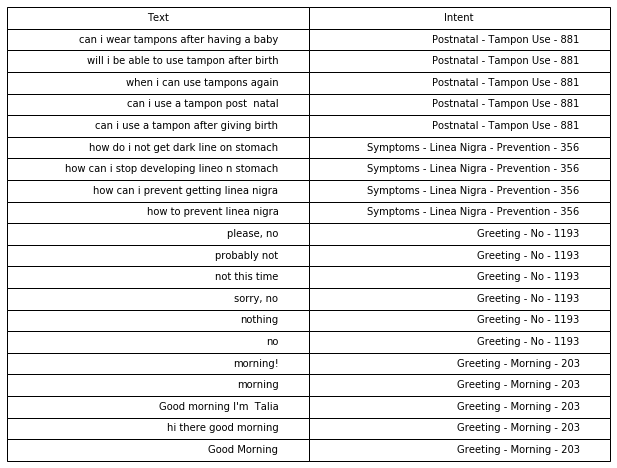

In [4]:
cell_text = [
    [item, y_data[idx] + ' - ' + str(int(y_train[idx]))] 
    for (idx, item) in enumerate(X_train)
]
plt.table(cellText=cell_text[:20],
          colLabels=['Text', 'Intent'],
          loc='center') \
   .scale(1.8,1.8)
plt.axis('off')
plt.show()

In [5]:
print('Number of samples: %s, classes: %s' % (len(X_train), num_classes))

Number of samples: 10256, classes: 1427


Save the classes descriptions as json

In [6]:
import json

with open(CLASSES_FILE, 'w') as classes_file:
    json.dump(classes, classes_file)

In [7]:
import torch
torch.__version__

'0.4.0a0+5463a4a'

Start training the classification model and save

In [8]:
training_data = [(item, y_train[idx]) for idx, item in enumerate(X_train)]

losses, model = trainIters(training_data, 
                           classes, 
                           n_iters=50, 
                           log_every=5, 
                           verbose=1, 
                           learning_rate=1e-3, 
                           batch_size=64)

Training started
Importing /Users/2359media/Documents/botbot-nlp/data/fasttext/crawl-300d-2M.vec...
3m 4s (- 27m 40s) (5 10%) 0.1106 - accuracy: 0.0111
5m 42s (- 22m 49s) (10 20%) 0.0892 - accuracy: 0.0683
9m 45s (- 22m 46s) (15 30%) 0.0567 - accuracy: 0.4047
12m 32s (- 18m 48s) (20 40%) 0.0308 - accuracy: 0.7113
15m 23s (- 15m 23s) (25 50%) 0.0181 - accuracy: 0.8400
17m 59s (- 11m 59s) (30 60%) 0.0121 - accuracy: 0.8863
21m 2s (- 9m 0s) (35 70%) 0.0091 - accuracy: 0.9048
23m 57s (- 5m 59s) (40 80%) 0.0074 - accuracy: 0.9126
27m 16s (- 3m 1s) (45 90%) 0.0064 - accuracy: 0.9154
30m 15s (- 0m 0s) (50 100%) 0.0058 - accuracy: 0.9172


Plot the losses graph (this helps choosing number of epochs and learning rate)

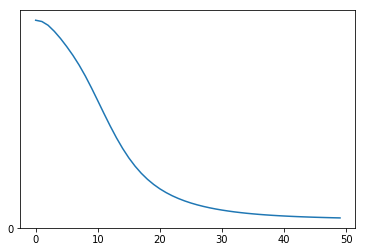

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
fig, ax = plt.subplots()
loc = ticker.MultipleLocator(base=5)
ax.yaxis.set_major_locator(loc)
plt.plot(losses)

Test the trained model

In [10]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from common.utils import argmax, to_scalar

from text_classification.fast_text.model import process_sentences

TEST_SENTENCE = 'My wife is expecting a child'

result = model(*process_sentences([TEST_SENTENCE]))
result = F.softmax(result, dim=1)
max_idx = argmax(result)
print((classes[max_idx], to_scalar(result[0][max_idx])))

('SmallTalk - WifePregnant', 0.9999999403953552)


Getting the top 5 results

In [11]:
topk_probs, topk_idxs = result.topk(5, dim=1)

for idx, result_idx in enumerate(topk_idxs[0]):
    print((classes[to_scalar(result_idx)], to_scalar(topk_probs[0][idx])))

('SmallTalk - WifePregnant', 0.9999999403953552)
('SmallTalk - Incorrect', 6.83399221657055e-08)
('BabyNames', 4.387011642847938e-09)
('Birth - Caesarean - Want', 3.6640734890625026e-09)
('General - Gender- PredictorChart', 3.0899587333266254e-09)
